In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../ztf_early_bumps/')
from supernova import Supernova

import sncosmo
import ztfidr
ztf_sample = ztfidr.get_sample()
ztf_df = ztf_sample.get_data()

In [119]:
def load_sn(ztfname: str) -> [pd.DataFrame, float]:
    """Loads a ZTF supernova and its properties.
    """
    # load SN and info
    sn = Supernova(ztfname, tmax=100)
    sn_info = ztf_sample.data.loc[ztfname]
    sn_df = sn.lc_df.copy()
    # rename filters
    for band in sn_df["filter"].unique():
        model_band = f"{band[:-1]}::{band[-1]}"  # e.g. ztf::g
        sn_df.replace(band, model_band, inplace=True)
    # get properties
    z = sn_info.redshift
    t0 = sn_info.t0
    mwebv = sn_info.mwebv
    # get phases
    sn_df["phase"] = (sn.lc_df.mjd.values - t0) / (1 + z)
    # rename some columns and add mag system
    sn_df.rename(columns={"filter": "band", "ZP":"zp"}, inplace=True)
    sn_df["zpsys"] = "ab"
    columns = ["mjd", "phase", "band", "flux", "flux_err", "zp", "zpsys"]
    sn_df = sn_df[columns]

    return sn_df, z, mwebv
    
class SED(object):
    """Creates a Spectral Energy Distribution (SED) object from
    an sncosmo source.
    """
    def __init__(self, source: str, z: float, mwebv: float = 0.0, 
                 phase_range: tuple[float, float] = (-10, 90), **kwargs: dict):
        """
        Parameters
        ----------
        source: sncosmo source.
        z: redshift.
        mwebv: Milky-Way dust extinction.
        """
        self.source = source
        self.z = z
        self.mwebv = mwebv
        self.load_model(source)
        self.set_parameters(**kwargs)
        # set other parameters
        self.bands = ['ztf::g', 'ztf::r', 'ztf::i']
        self.colours = {'ztf::g':"green", 'ztf::r':"red", 'ztf::i':"gold"}
        # time range
        self.phase_range = phase_range
        step = 0.1
        self.times = np.arange(self.phase_range[0], 
                               self.phase_range[1] + step,
                               step
                              )
    
    def load_model(self, source, mw_dust_law: sncosmo.PropagationEffect = None) -> sncosmo.models.Model:
        self.model = sncosmo.Model(source=self.source)
        # Milky-Way dust law
        if mw_dust_law is None:
            mw_dust_law = sncosmo.CCM89Dust()
        self.model.add_effect(mw_dust_law, 'mw', 'obs')

    def set_parameters(self, **kwargs):
        self.model.set(**kwargs)
        self.rest_model = deepcopy(self.model)  # model @ z=0
        self.model.set(z=self.z)
        self.model.set(mwebv=self.mwebv)

    def plot_lightcurves(self, zp: float = None):
        """Plots the model light curves.
        """
        if zp is None:
            zp = 30
        fig, ax = plt.subplots(figsize=(6, 4))
        for band, colour in self.colours.items():
            flux = self.model.bandflux(band, self.times, zp=zp, zpsys='ab')
            mag = -2.5 * np.log10(flux) + zp
            ax.plot(self.times, mag, label=band, color=colour)
        
        plt.gca().invert_yaxis()  # Brighter is up
        ax.set_xlabel('Days since B-maximum', fontsize=16)
        ax.set_ylabel('Apparent Magnitude', fontsize=16)
        ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
        ax.tick_params('both', labelsize=14)
        ax.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_kcorr(self):
        """Plots the same-filter K-correction.
        """
        zp = 30
        fig, ax = plt.subplots(figsize=(6, 4))
        for band, colour in self.colours.items():
            rest_flux = self.rest_model.bandflux(band, self.times, zp=zp, zpsys='ab')
            flux = self.model.bandflux(band, self.times, zp=zp, zpsys='ab') 
            kcorr = -2.5 * np.log10(rest_flux / flux)
            ax.plot(self.times, kcorr, label=band, color=colour)
        
        ax.set_xlabel('Days since B-maximum', fontsize=16)
        ax.set_ylabel(r'$K$-correction (mag)', fontsize=16)
        ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
        ax.tick_params('both', labelsize=14)
        ax.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

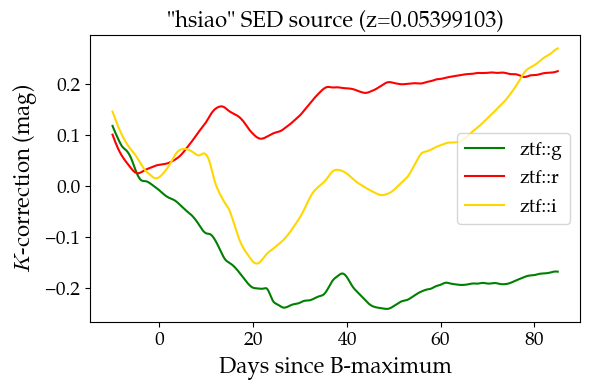

In [120]:
ztfname = "ZTF18abvtcyi"
sn_df, z, mwebv = load_sn(ztfname)
sed = SED("hsiao", z=z, mwebv=mwebv, phase_range=(-10, 85))
sed.plot_kcorr()

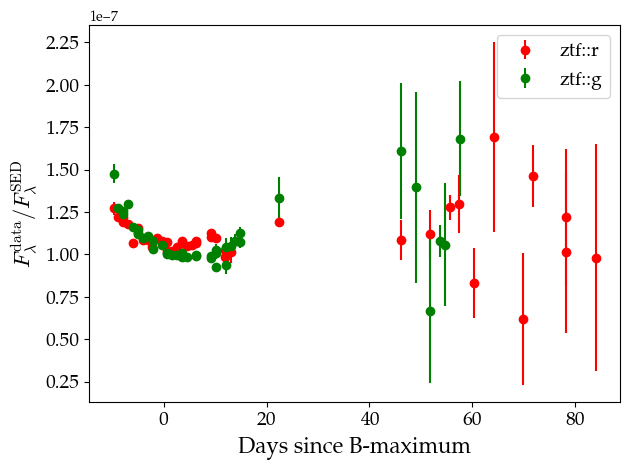

In [121]:
def calculate_kcorr()
    pmin, pmax = sed.phase_range
    ratios = {}
    ratio_times, ratio_waves = np.empty(0), np.empty(0)
    ratio_fluxes, ratio_errors = np.empty(0), np.empty(0)
    
    fig, ax = plt.subplots()
    for band in sn_df.band.unique():
        # load band data
        band_df = sn_df[sn_df.band==band]
        # select phase range
        times = band_df.phase.values
        phase_mask = (pmin <= times) & (times <= pmax)
        times = times[phase_mask]
        # get light-curve data
        flux, flux_err = band_df.flux.values[phase_mask], band_df.flux_err.values[phase_mask]
        zp = band_df.zp.values[phase_mask]
        zpsys = band_df.zpsys.values[phase_mask]
        eff_wave = sncosmo.get_bandpass(band).wave_eff
        # get model flux
        model_flux = sed.model.bandflux(band, times, zp=zp, zpsys=zpsys)
        # get ratios
        ratio_flux = flux / model_flux
        ratio_error = flux_err / model_flux
        # store data
        ratios[band] = {"times":times, 
                        "ratio":ratio_flux, 
                        "error":ratio_error,
                       }
        ratio_times = np.r_[ratio_times, times]
        ratio_waves = np.r_[ratio_waves, [eff_wave] * len(times)]
        ratio_fluxes = np.r_[ratio_fluxes, ratio_flux]
        ratio_errors = np.r_[ratio_errors, ratio_error]
    
        # plot
        ax.errorbar(times, ratio_flux, yerr=ratio_error, 
                    ls="", marker="o", color=sed.colours[band], label=band)
        ax.set_xlabel('Days since B-maximum', fontsize=16)
        ax.set_ylabel(r'$F_{\lambda}^{\rm data} / F_{\lambda}^{\rm SED}$', fontsize=16)
        ax.tick_params('both', labelsize=14)
    
    ax.legend(fontsize=14)
    plt.tight_layout()

In [122]:
import jax
import jaxopt
import numpy as np
import jax.numpy as jnp
from tinygp import GaussianProcess, kernels, transforms

jax.config.update("jax_enable_x64", True)

def prepare_gp_inputs(times, wavelengths, fluxes, flux_errors):
    X = (times, wavelengths)

    # normalise fluxes - values have to be ideally above zero
    y_norm = np.copy(fluxes.max()) 
    y = (fluxes / y_norm).copy() 
    yerr = (flux_errors / y_norm).copy()

    return X, y, yerr, y_norm
    
def fit_gp_model(times, wavelengths, fluxes, flux_errors, k1='Matern52', fit_mean=False, 
                 time_scale=None, add_noise=True):
    
    assert k1 in ['Matern52', 'Matern32', 'ExpSquared'], "Not a valid kernel"
    def build_gp(params):
        """Creates a Gaussian Process model.
        """
        nonlocal time_scale, add_noise  # import from main function
        if time_scale is None:
            log_time_scale = params["log_scale"][0]
        else:
            log_time_scale = np.log(time_scale)
        if add_noise is True:
            noise = jnp.exp(2 * params["log_noise"])
        else:
            noise = 0.0
        log_wave_scale = params["log_scale"][-1]

        # select time-axis kernel
        if k1 == 'Matern52':
            kernel1 = transforms.Subspace(0, kernels.Matern52(scale=jnp.exp(log_time_scale)))
        elif k1 == 'Matern32':
            kernel1 = transforms.Subspace(0, kernels.Matern32(scale=jnp.exp(log_time_scale)))
        else:
            kernel1 = transforms.Subspace(0, kernels.ExpSquared(scale=jnp.exp(log_time_scale)))
        # wavelength-axis kernel
        kernel2 = transforms.Subspace(1, kernels.ExpSquared(scale=jnp.exp(log_wave_scale)))
        
        kernel = jnp.exp(params["log_amp"]) * kernel1 * kernel2
        diag = yerr ** 2 + noise
        
        if fit_mean is True:
            mean = jnp.exp(params["log_mean"])
        else:
            mean = None

        return GaussianProcess(kernel, X, diag=diag, mean=mean)

    @jax.jit
    def loss(params):
        """Loss function for the Gaussian Process hyper-parameters optimisation.
        """
        return -build_gp(params).condition(y).log_probability
    
    X, y, yerr, _ = prepare_gp_inputs(times, wavelengths, fluxes, flux_errors)

    # GP hyper-parameters
    scales = np.array([30, 2000]) # units: days, angstroms
    
    params = {
        "log_amp": jnp.log(y.var()),
        "log_scale": jnp.log(scales),
        "log_noise": jnp.log(np.mean(yerr)),
    }
    if fit_mean is True:
        params.update({"log_mean": jnp.log(np.average(y, weights=1/yerr**2))})

    # Train the GP model
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    gp_model = build_gp(soln.params)
    
    return gp_model

def gp_predict(times_pred, wavelengths_pred, ratio_pred, error_pred):
    X_test, y, _, y_norm = prepare_gp_inputs(times_pred, wavelengths_pred, 
                                             ratio_pred, error_pred, 
                                            )
    # GP prediction
    mu, var = gp_model.predict(y, X_test=X_test, return_var=True)
    # renormalise outputs and convert jax-Array to numpy-array
    mu = np.array(mu) * y_norm
    var = np.array(var) * y_norm ** 2

    return mu, var

In [138]:
gp_model = fit_gp_model(ratio_times, ratio_waves, ratio_fluxes, ratio_errors, k1='ExpSquared', fit_mean=True)

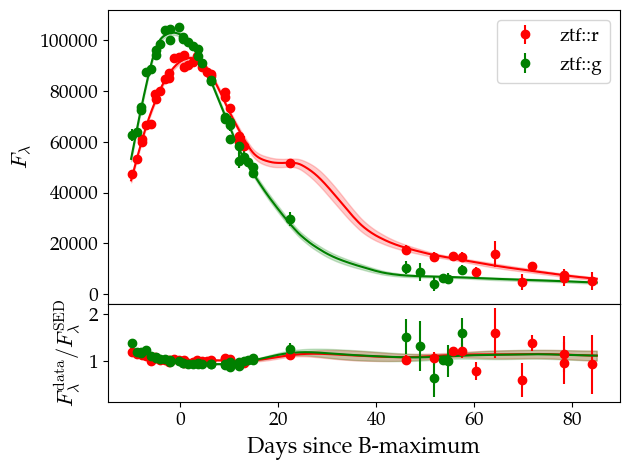

In [139]:
times_grid = np.arange(pmin, pmax + 0.1, 0.1)

fig, ax = plt.subplots(2, 1, height_ratios=(3, 1), gridspec_kw={"hspace":0})
for band in sn_df.band.unique():
    band_df = sn_df[sn_df.band==band]
    # select phase range
    times = band_df.phase.values
    phase_mask = (pmin <= times) & (times <= pmax)
    times = times[phase_mask]
    # get light-curve data
    flux, flux_err = band_df.flux.values[phase_mask], band_df.flux_err.values[phase_mask]
    zp = band_df.zp.values[phase_mask]
    zpsys = band_df.zpsys.values[phase_mask]
    eff_wave = sncosmo.get_bandpass(band).wave_eff

    # get model flux
    model_flux = sed.model.bandflux(band, times_grid, zp=zp[0], zpsys=zpsys[0])
    # kcorr prediction
    waves_grid = np.array([eff_wave] * len(times_grid))
    ratio_fit, var_fit = gp_predict(times_grid, waves_grid, ratio_fluxes, ratio_errors)
    error_fit = np.sqrt(var_fit)
    
    # plot model
    colour = sed.colours[band]
    ax[0].plot(times_grid, model_flux * ratio_fit, color=colour)
    ax[0].fill_between(times_grid, 
                       model_flux * (ratio_fit - error_fit), 
                       model_flux * (ratio_fit + error_fit),                        
                       color=colour, alpha=0.2)
    # plot data
    ax[0].errorbar(times, flux, flux_err, ls="", marker="o", color=colour, label=band)

    # plot residuals
    norm = np.average(ratio_fluxes, weights=1 / ratio_errors ** 2)  # for plotting only
    ax[1].plot(times_grid, ratio_fit / norm, color=colour)
    ax[1].fill_between(times_grid, 
                       (ratio_fit - error_fit) / norm, 
                       (ratio_fit + error_fit) / norm, 
                       alpha=0.2, color=colour)
    data = ratios[band]
    ax[1].errorbar(data["times"], data["ratio"] / norm, data["error"] / norm, 
                   ls="", marker="o", color=colour)

    ax[0].set_ylabel(r'$F_{\lambda}$', fontsize=16)
    ax[1].set_xlabel('Days since B-maximum', fontsize=16)
    ax[1].set_ylabel(r'$F_{\lambda}^{\rm data} / F_{\lambda}^{\rm SED}$', fontsize=16)
    for i in range(2):
        ax[i].tick_params('both', labelsize=14)

ax[0].legend(fontsize=14)
plt.tight_layout()

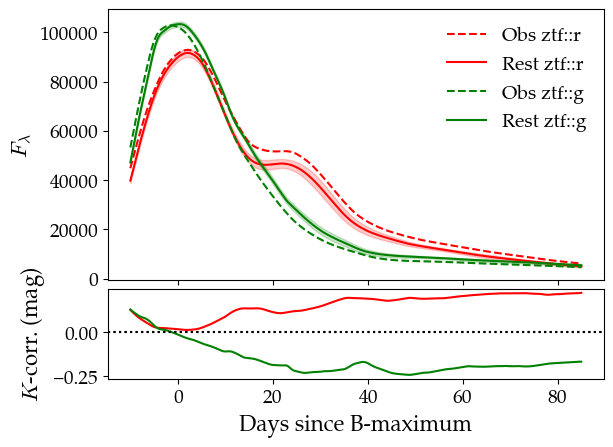

In [141]:
times_grid = np.arange(pmin, pmax + 0.1, 0.1)

fig, ax = plt.subplots(2, 1, height_ratios=(3, 1), gridspec_kw={"hspace":0.05})
for i, band in enumerate(sn_df.band.unique()):
    band_df = sn_df[sn_df.band==band]
    # select phase range
    times = band_df.phase.values
    phase_mask = (pmin <= times) & (times <= pmax)
    times = times[phase_mask]
    zp = band_df.zp.values[phase_mask]
    zpsys = band_df.zpsys.values[phase_mask]
    eff_wave = sncosmo.get_bandpass(band).wave_eff

    # get rest-frame model flux
    rest_model_flux = sed.rest_model.bandflux(band, times_grid, zp=zp[0], zpsys=zpsys[0])
    # kcorr prediction
    waves_grid = np.array([eff_wave * (1 + 0.1)] * len(times_grid))
    ratio_fit, var_fit = gp_predict(times_grid, waves_grid, ratio_fluxes, ratio_errors)
    error_fit = np.sqrt(var_fit)
    rest_kcorr_flux = rest_model_flux * ratio_fit
    rest_kcorr_error = rest_model_flux * error_fit
    
    # get observer-frame model flux
    model_flux = sed.model.bandflux(band, times_grid, zp=zp[0], zpsys=zpsys[0])
    # kcorr prediction
    waves_grid = np.array([eff_wave] * len(times_grid))
    ratio_fit, var_fit = gp_predict(times_grid, waves_grid, ratio_fluxes, ratio_errors)
    error_fit = np.sqrt(var_fit)
    kcorr_flux = model_flux * ratio_fit
    kcorr_error = model_flux * error_fit
    
    # plot model
    colour = sed.colours[band]
    norm = rest_kcorr_flux.max()
    ax[0].plot(times_grid, kcorr_flux + i, color=colour, ls="dashed", label=f"Obs {band}")
    ax[0].plot(times_grid, rest_kcorr_flux + i, color=colour, ls="solid", label=f"Rest {band}")
    ax[0].fill_between(times_grid, 
                       (rest_kcorr_flux - rest_kcorr_error)  + i, 
                       (rest_kcorr_flux + rest_kcorr_error)  + i,                        
                       color=colour, alpha=0.2)
    # residual
    model_kcorr = -2.5 * np.log10(rest_kcorr_flux / kcorr_flux)
    ax[1].plot(times_grid, model_kcorr, color=colour, ls="solid")
    ax[1].axhline(0.0, ls="dotted", color="k")

    ax[0].set_ylabel(r'$F_{\lambda}$', fontsize=16)
    ax[1].set_ylabel(r'$K$-corr. (mag)', fontsize=16)
    ax[1].set_xlabel('Days since B-maximum', fontsize=16)
    for i in range(2):
        ax[i].tick_params('both', labelsize=14)

ax[0].legend(fontsize=14, framealpha=0)
plt.show()